# [CDAF] Atividade 6

## Nome e matrícula
Nome: Arthur Pontes Nader
Matrícula: 2019022294

## Referências
- [1] https://www.ecmlpkdd2019.org/downloads/paper/701.pdf
- [2] https://dtai.cs.kuleuven.be/sports/blog/player-vectors:-characterizing-soccer-players'-playing-style
- [3] https://dtai.cs.kuleuven.be/sports/player_vectors
- [4] https://github.com/TomDecroos/matplotsoccer

## Introdução
- Nessa atividade, temos implementado o "Player Vectors", método proposto em [1] para caracterizar o estilo de jogo de jogadores baseado nas localizações que realizam cada tipo de ação.
- [2] apresenta o conteúdo do paper em [1] de forma mais resumida e visual, em formato de blog.
- [3] oferece uma demo interativa com uma aplicação do método no contexto de comparar a similaridade entre jogadores.
- [4] é uma biblioteca para plotar visualizações de partidas de futebol. Além disso, ela tem uma função pronta para criar heatmaps de ações de jogadores, que é util para o nosso contexto.

## Intruções
- Para cada header abaixo do notebook, vocês devem explicar o que foi feito e à qual seção/subseção/equação de [1] ela corresponde. Justifique suas respostas.
- Além disso, vocês devem montar um diagrama do fluxo de funções/tarefas de toda a pipeline do Player Vectors abaixo. Esse diagrama deve ser enviado como arquivo na submissão do Moodle, para além deste notebook.

### Carregando os dados

In [1]:
import numpy as np
import pandas as pd

In [2]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        team_match = pd.DataFrame(matches.loc[i, 'teamsData']).T
        team_match['matchId'] = matches.loc[i, 'wyId']
        team_matches.append(team_match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)

    return matches, team_matches

In [3]:
def get_position(x):
    return x['name']

def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players['player_name'] = players['firstName'] + ' ' + players['lastName']
    players['role'] = players['role'].apply(get_position)
    players = players[['wyId', 'player_name', 'role']].rename(columns={'wyId': 'player_id'})

    return players

In [4]:
def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(columns={
        'id': 'event_id',
        'eventId': 'type_id',
        'subEventId': 'subtype_id',
        'teamId': 'team_id',
        'playerId': 'player_id',
        'matchId': 'game_id'
    })
    events['milliseconds'] = events['eventSec'] * 1000
    events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

    return events

In [5]:
def load_minutes_played_per_game(path):
    minutes = pd.read_json(path_or_buf=path)
    minutes = minutes.rename(columns={
        'playerId': 'player_id',
        'matchId': 'game_id',
        'teamId': 'team_id',
        'minutesPlayed': 'minutes_played'
    })
    minutes = minutes.drop(['shortName', 'teamName', 'red_card'], axis=1)

    return minutes

In [6]:
leagues = ['England', 'Spain']
events = {}
matches = {}
team_matches = {}
game_minutes = {}
for league in leagues:
    path = r'matches_{}.json'.format(league)
    matches[league], team_matches[league] = load_matches(path)
    path = r'events_{}.json'.format(league)
    events[league] = load_events(path)
    path = r'minutes_played_per_game_{}.json'.format(league)
    game_minutes[league] = load_minutes_played_per_game(path)

In [7]:
path = r'players.json'
players = load_players(path)
players['player_name'] = players['player_name'].str.decode('unicode-escape')

In [8]:
def calculate_minutes_per_season(minutes_per_game):
    minutes_per_season = minutes_per_game.groupby('player_id', as_index=False)['minutes_played'].sum()

    return minutes_per_season

O conjunto de funções acima são utilizadas para carregar e pré-processar dados relacionados as partidas de futebol, jogadores, eventos, minutos jogados por partida e minutos jogados por temporada das ligas escolhidas (Inglaterra e Espanha). Essa primeira parte corresponde à subseção "2.1 - Event Stream Data" do artigo.

### SPADL

In [9]:
from tqdm import tqdm
import socceraction.spadl as spd

In [10]:
def spadl_transform(events, team_matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
        match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)

    return spadl

In [11]:
spadl = {}
for league in leagues:
    spadl[league] = spadl_transform(events=events[league], team_matches=team_matches[league])

100%|█████████████████████████████████████████| 380/380 [05:26<00:00,  1.16it/s]


In [46]:
spadl["England"].head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,2499719,1,2.758649,1609,25413,51.45,34.68,32.55,14.96,177959171,0,0,1,0,pass,success,foot
1,2499719,1,4.946850,1609,370224,32.55,14.96,53.55,17.00,177959172,0,0,1,1,pass,success,foot
2,2499719,1,6.542188,1609,3319,53.55,17.00,36.75,19.72,177959173,1,0,1,2,pass,success,head
3,2499719,1,8.143395,1609,120339,36.75,19.72,43.05,3.40,177959174,1,0,1,3,pass,success,head
4,2499719,1,10.302366,1609,167145,43.05,3.40,75.60,8.16,177959175,0,0,1,4,pass,success,foot


A função acima recebe os eventos e as informações dos times de cada partida e realiza a transformação dos eventos para o formato SPADL. A subseção do artigo que faz referência a essa transformação também é a mesma do pré-processamento: "2.1 - Event Stream Data".

### Construção de Heatmaps

In [12]:
import scipy
import matplotsoccer as mps

In [13]:
def construct_heatmaps(spadl, season_minutes, action_type):
    heatmaps = {}
    if action_type == 'pass':
        heatmaps['start'] = {}
        heatmaps['end'] = {}
    for player_id in tqdm(season_minutes['player_id'].tolist()):
        mask = (spadl['player_id'] == player_id) & (spadl['type_name'] == action_type)
        player_actions = spadl[mask]
        if action_type != 'pass':
            heatmaps[player_id] = mps.count(x=player_actions['start_x'], y=player_actions['start_y'], n=25, m=16)
            heatmaps[player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps[player_id] = scipy.ndimage.gaussian_filter(heatmaps[player_id], 1)
        else:
            heatmaps['start'][player_id] = mps.count(x=player_actions['start_x'], y=player_actions['start_y'], n=25, m=16)
            heatmaps['start'][player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps['start'][player_id] = scipy.ndimage.gaussian_filter(heatmaps['start'][player_id], 1)
            heatmaps['end'][player_id] = mps.count(x=player_actions['end_x'], y=player_actions['end_y'], n=25, m=16)
            heatmaps['end'][player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps['end'][player_id] = scipy.ndimage.gaussian_filter(heatmaps['end'][player_id], 1)

    return heatmaps

In [14]:
season_minutes = {}
for league in leagues:
    season_minutes[league] = calculate_minutes_per_season(minutes_per_game=game_minutes[league])
    mask = (season_minutes[league]['minutes_played'] >= 900) & (season_minutes[league]['player_id'].isin(players.loc[players['role'] != 'Goalkeeper', 'player_id']))
    season_minutes[league] = season_minutes[league][mask]

In [15]:
action_types = ['shot', 'pass', 'cross', 'dribble']
heatmaps = {}
for league in leagues:
    heatmaps[league] = {}
    for at in action_types:
        heatmaps[league][at] = construct_heatmaps(spadl=spadl[league], season_minutes=season_minutes[league], action_type=at)

100%|█████████████████████████████████████████| 324/324 [00:14<00:00, 22.50it/s]


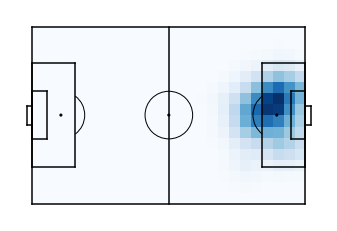

<AxesSubplot:>

In [16]:
mps.heatmap(heatmaps['Spain']['shot'][3359])

A função *construct_heatmaps* recebe dados SPADL, o dataframe de minutos jogados por temporada e um tipo de ação. Com esses dados, gera-se mapas de calor relacionados a chutes, passes, dribles e cruzamentos para os jogadores com base nas coordenadas dessass ações, sendo que esses são ajustados de acordo com a quantidade de minutos jogados e aplicadando um filtro gaussiano. Essa parte  está relacionada às seguintes subseções da seção 4: "4.1 Selecting Relevant Action Types" e "4.2 - Constructing Heatmaps".

### Comprimindo heatmaps para vetores

In [17]:
def heatmaps_to_vectors(heatmaps, action_type):
    if action_type != 'pass':
        vectorized_heatmaps = np.array([heatmaps[player_id].reshape(-1) for player_id in heatmaps.keys()])
    else:
        vectorized_heatmaps = np.array([np.concatenate([heatmaps['start'][player_id].reshape(-1), heatmaps['end'][player_id].reshape(-1)]) for player_id in heatmaps['start'].keys()])

    return vectorized_heatmaps

In [18]:
vectorized_heatmaps = {}
for league in leagues:
    vectorized_heatmaps[league] = {}
    for act_type in action_types:
        vectorized_heatmaps[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps[league][act_type], action_type=act_type)

In [62]:
vectorized_heatmaps["Spain"]["shot"].shape, vectorized_heatmaps["Spain"]["pass"].shape

((324, 400), (324, 800))

In [63]:
vectorized_heatmaps["Spain"]["pass"][:5]

array([[0.00000000e+00, 0.00000000e+00, 1.16893201e-09, ...,
        4.76707830e-02, 5.00256137e-02, 4.16294991e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.53890568e-01, 1.27785987e-01, 1.20594519e-01],
       [9.57895379e-02, 1.43876743e-01, 1.99343206e-01, ...,
        4.74144553e-03, 1.09739100e-03, 1.55586757e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.36571681e-01, 1.35300594e-01, 1.46851313e-01],
       [5.47430367e-02, 7.77287040e-02, 9.62784582e-02, ...,
        2.54265157e-02, 2.50730330e-02, 4.48648046e-02]])

Já a função acima recebe os mapas de calor gerados e um tipo de ação e converte esses mapas de calor em vetores, onde cada vetor representa um jogador. Se o tipo de ação for "pass", os mapas de calor de início e fim de passe são concatenados em um único vetor. O principal objetivo dessa transformação é capturar a informação disponível no heatmap em um vetor. Essa etapa está relacionada à subseção "4.3 - Compressing Heatmaps to Vectors" do artigo [1].

### NMF

In [19]:
from sklearn.decomposition import NMF

In [20]:
def nmf_decomposition(vectorized_heatmaps, n_components):
    nmf = NMF(n_components=n_components, init='nndsvda', random_state=0)
    nmf.fit(vectorized_heatmaps)

    return nmf

In [21]:
n_components = {'shot': 4, 'pass': 5, 'cross': 4, 'dribble': 5}
concat_vectors = {}
nmfs = {}
for act_type in action_types:
    concat_vectors[act_type] = np.concatenate([vectorized_heatmaps['England'][act_type], vectorized_heatmaps['Spain'][act_type]])
    nmfs[act_type] = nmf_decomposition(vectorized_heatmaps=concat_vectors[act_type], n_components=n_components[act_type])

In [72]:
nmfs['shot']

NMF(init='nndsvda', n_components=4, random_state=0)

O objetivo dessa parte é realizar a decomposição dos vetores de mapas de calor usando  a técnica de decomposição em componentes não negativos, permitindo a identificação de padrões e características relevantes nos dados. Esses componentes são capazes de descrever melhor a variação nos mapas de calor. Essa etapa está relacionada às subseções "4.3 - Compressing Heatmaps to Vectors" e "4.4 Assembling Player Vectors" do artigo.

### Reconstruction Evaluation

In [22]:
for act_type in action_types:
    print('{} Reconstruction evaluation\n'.format(act_type))
    print('Reconstruction error from NMF object: {}'.format(nmfs[act_type].reconstruction_err_))
    reconst_vectors = np.dot(nmfs[act_type].components_.T, nmfs[act_type].transform(concat_vectors[act_type]).T).T
    reconst_error = np.sqrt(np.sum((concat_vectors[act_type] - reconst_vectors) ** 2))
    print('Manual reconstruction error: {}'.format(reconst_error))
    print('Mean reconstruction error: {}'.format(reconst_error / (concat_vectors[act_type].shape[1])))
    print('--------------------------------\n')

shot Reconstruction evaluation

Reconstruction error from NMF object: 1.322487922632152
Manual reconstruction error: 1.322487918480089
Mean reconstruction error: 0.0033062197962002225
--------------------------------

pass Reconstruction evaluation

Reconstruction error from NMF object: 28.196261893627756
Manual reconstruction error: 28.196261647153566
Mean reconstruction error: 0.035245327058941955
--------------------------------

cross Reconstruction evaluation

Reconstruction error from NMF object: 2.3365384800195814
Manual reconstruction error: 2.336538445866538
Mean reconstruction error: 0.005841346114666345
--------------------------------

dribble Reconstruction evaluation

Reconstruction error from NMF object: 4.008096593968764
Manual reconstruction error: 4.008096580590021
Mean reconstruction error: 0.010020241451475051
--------------------------------



Por meio da análise do erro, essas medidas avaliam o quanto a decomposição NMF consegue reconstruir os vetores de mapas de calor e a qualidade da reconstrução. Essas avaliações do modelo parecem não serem citadas diretamente no artigo.

### Deanonymization Evaluation

In [23]:
matches_1st = {}
matches_2nd = {}
spadl_1st = {}
spadl_2nd = {}
season_minutes_1st = {}
season_minutes_2nd = {}
for league in leagues:
    matches[league] = matches[league].sort_values(by='dateutc').reset_index(drop=True)
    matches_1st[league] = matches[league].loc[: int(len(matches[league]) / 2) - 1, 'wyId'].values.tolist()
    matches_2nd[league] = matches[league].loc[int(len(matches[league]) / 2) :, 'wyId'].values.tolist()
    season_minutes_1st[league] = calculate_minutes_per_season(game_minutes[league][game_minutes[league]['game_id'].isin(matches_1st[league])])
    season_minutes_2nd[league] = calculate_minutes_per_season(game_minutes[league][game_minutes[league]['game_id'].isin(matches_2nd[league])])
    season_minutes_1st[league] = season_minutes_1st[league][season_minutes_1st[league]['minutes_played'] >= 900]
    season_minutes_2nd[league] = season_minutes_2nd[league][season_minutes_2nd[league]['minutes_played'] >= 900]
    season_minutes_1st[league] = season_minutes_1st[league][season_minutes_1st[league]['player_id'].isin(season_minutes_2nd[league]['player_id'])]
    season_minutes_2nd[league] = season_minutes_2nd[league][season_minutes_2nd[league]['player_id'].isin(season_minutes_1st[league]['player_id'])]
    mask_1st = (spadl[league]['game_id'].isin(matches_1st[league])) & (spadl[league]['player_id'].isin(season_minutes_1st[league]['player_id']))
    spadl_1st[league] = spadl[league][mask_1st]
    mask_2nd = (spadl[league]['game_id'].isin(matches_2nd[league])) & (spadl[league]['player_id'].isin(season_minutes_2nd[league]['player_id']))
    spadl_2nd[league] = spadl[league][mask_2nd]

In [24]:
heatmaps_1st = {}
heatmaps_2nd = {}
for league in leagues:
    heatmaps_1st[league] = {}
    heatmaps_2nd[league] = {}
    for at in action_types:
        heatmaps_1st[league][at] = construct_heatmaps(spadl=spadl_1st[league], season_minutes=season_minutes_1st[league], action_type=at)
        heatmaps_2nd[league][at] = construct_heatmaps(spadl=spadl_2nd[league], season_minutes=season_minutes_2nd[league], action_type=at)

100%|█████████████████████████████████████████| 154/154 [00:02<00:00, 52.72it/s]


In [25]:
vectorized_heatmaps_1st = {}
vectorized_heatmaps_2nd = {}
for league in leagues:
    vectorized_heatmaps_1st[league] = {}
    vectorized_heatmaps_2nd[league] = {}
    for act_type in action_types:
        vectorized_heatmaps_1st[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps_1st[league][act_type], action_type=act_type)
        vectorized_heatmaps_2nd[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps_2nd[league][act_type], action_type=act_type)

In [26]:
def coefficients_transform(vectorized_heatmaps, nmf):
    return nmf.transform(vectorized_heatmaps)

In [27]:
vectorized_coefs_1st = {}
vectorized_coefs_2nd = {}
for league in leagues:
    vectorized_coefs_1st[league] = {}
    vectorized_coefs_2nd[league] = {}
    for act_type in action_types:
        vectorized_coefs_1st[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps_1st[league][act_type], nmf=nmfs[act_type])
        vectorized_coefs_2nd[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps_2nd[league][act_type], nmf=nmfs[act_type])

In [28]:
player_vectors_1st = {}
player_vectors_2nd = {}
for league in leagues:
    player_vectors_1st[league] = np.concatenate([vectorized_coefs_1st[league][act_type] for act_type in action_types], axis=1)
    player_vectors_2nd[league] = np.concatenate([vectorized_coefs_2nd[league][act_type] for act_type in action_types], axis=1)

In [29]:
player_vectors_1st = np.concatenate([player_vectors_1st[league] for league in leagues])
player_vectors_2nd = np.concatenate([player_vectors_2nd[league] for league in leagues])

In [30]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps_1st[league]['shot'].keys())

In [31]:
from sklearn.metrics import pairwise_distances

In [32]:
D = pairwise_distances(player_vectors_1st, player_vectors_2nd, metric="manhattan")

# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

rs = np.argmax(np.array([p_i[i, :] == player_ids[i] for i in range(p_i.shape[0])]), axis=1)

def mean_reciprocal_rank(rs):
    return np.mean(1. / (rs + 1))

def top_k(rs, k):
    return (rs < k).sum() / len(rs)

mrr = mean_reciprocal_rank(rs)
top1 = top_k(rs, 1)
top3 = top_k(rs, 3)
top5 = top_k(rs, 5)
top10 = top_k(rs, 10)

In [33]:
print('Top 1 = {}%'.format(round(top1 * 100, 1)))
print('Top 3 = {}%'.format(round(top3 * 100, 1)))
print('Top 5 = {}%'.format(round(top5 * 100, 1)))
print('Top 10 = {}%'.format(round(top10 * 100, 1)))
print('MRR = {}'.format(round(mrr, 3)))

Top 1 = 38.3%
Top 3 = 61.4%
Top 5 = 70.5%
Top 10 = 81.9%
MRR = 0.532


In [80]:
player_vectors_1st, player_vectors_2nd

(array([[0.00223934, 0.03153931, 0.        , ..., 0.31423043, 0.01300391,
         0.        ],
        [0.05245532, 0.14259178, 0.02865733, ..., 0.06975531, 0.03257529,
         0.03597058],
        [0.        , 0.08422903, 0.13241026, ..., 0.02571046, 0.        ,
         0.        ],
        ...,
        [0.01824185, 0.07307706, 0.13711788, ..., 0.0328364 , 0.        ,
         0.04994868],
        [0.15915945, 0.0202695 , 0.04029585, ..., 0.03100956, 0.01243341,
         0.        ],
        [0.02652117, 0.08702844, 0.03914576, ..., 0.050896  , 0.04752885,
         0.03426575]]),
 array([[0.01578703, 0.03544184, 0.        , ..., 0.23874233, 0.        ,
         0.        ],
        [0.02101294, 0.12642155, 0.0500112 , ..., 0.03289293, 0.00354506,
         0.02662011],
        [0.02433582, 0.04331273, 0.04824659, ..., 0.01484839, 0.05173633,
         0.        ],
        ...,
        [0.0334481 , 0.0682535 , 0.08170318, ..., 0.0062797 , 0.        ,
         0.06623623],
        [0.2

In [81]:
print("Matriz de distancias: \n", D)

Matriz de distancias: 
 [[0.         2.63187925 2.25151601 ... 1.63646291 2.02007184 1.74066137]
 [2.63187925 0.         2.18746624 ... 1.57147685 1.66012994 2.32987327]
 [2.25151601 2.18746624 0.         ... 1.39673056 1.10039074 1.74218632]
 ...
 [1.63646291 1.57147685 1.39673056 ... 0.         1.34622377 1.72432651]
 [2.02007184 1.66012994 1.10039074 ... 1.34622377 0.         1.58850405]
 [1.74066137 2.32987327 1.74218632 ... 1.72432651 1.58850405 0.        ]]


Nessa etapa, primeiramente realiza-se a divisão dos dados em duas partes, cada uma correspondendo a uma metade do campeonato. Em seguida, a matriz de distâncias é calculada entre os vetores de jogadores da primeira parte e da segunda parte da temporada, utilizando a métrica de distância de Manhattan. Por fim, é verificado se o jogador aparece no topo de seu próprio rank, o que é um indício de que o estilo do jogador foi caracterizado com sucesso. Essa parte do código está mais relacionada à subseção "5.4 Player Retrieval from Anonymized Match Event Stream Data" do artigo.

### Explore Similar Players

In [34]:
vectorized_coefs = {}
for league in leagues:
    vectorized_coefs[league] = {}
    for act_type in action_types:
        vectorized_coefs[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps[league][act_type], nmf=nmfs[act_type])

In [35]:
player_vectors = {}
for league in leagues:
    player_vectors[league] = np.concatenate([vectorized_coefs[league][act_type] for act_type in action_types], axis=1)

In [36]:
player_vectors = np.concatenate([player_vectors[league] for league in leagues])

In [37]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps[league]['shot'].keys())

In [38]:
D = pairwise_distances(player_vectors, player_vectors, metric="manhattan")
# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

In [39]:
similar_players = pd.DataFrame(data=p_i[:, : 11], columns=['player_id'] + ['{}th_similar'.format(i) for i in range(1, 11)])

In [40]:
players = players[players['player_id'].isin(similar_players['player_id'])].reset_index(drop=True)

In [41]:
id_to_name = {}
for i in range(len(players)):
    id_to_name[players.loc[i, 'player_id']] = players.loc[i, 'player_name']

In [42]:
similar_players = similar_players.replace(id_to_name)

In [88]:
similar_players[similar_players["player_id"] == "Lionel Andrés Messi Cuccittini"]

,player_id,1th_similar,2th_similar,3th_similar,4th_similar,5th_similar,6th_similar,7th_similar,8th_similar,9th_similar,10th_similar
338,Lionel Andrés Messi Cuccittini,Christian Dannemann Eriksen,Erik Lamela,Álvaro Borja Morata Martín,Eden Hazard,Rodrigo Moreno Machado,Gerard Moreno Balaguero,Romelu Lukaku Menama,Roberto Firmino Barbosa de Oliveira,Aaron Ramsey,Antoine Griezmann


In [94]:
similar_players[similar_players["player_id"] == "Cristiano Ronaldo dos Santos Aveiro"]

,player_id,1th_similar,2th_similar,3th_similar,4th_similar,5th_similar,6th_similar,7th_similar,8th_similar,9th_similar,10th_similar
326,Cristiano Ronaldo dos Santos Aveiro,Luis Fernando Muriel Fruto,Sergio Leonel Agüero del Castillo,El-Hadji Baye Oumar Niasse,Luis Alberto Suárez Díaz,Pierre-Emerick Aubameyang,Florin Andone,Heung-Min Son,Wissam Ben Yedder,Enrique García Martínez,Diego Alejandro Rolán Silva


In [106]:
similar_players[similar_players["player_id"] == "Andrés Iniesta Luján"]

,player_id,1th_similar,2th_similar,3th_similar,4th_similar,5th_similar,6th_similar,7th_similar,8th_similar,9th_similar,10th_similar
336,Andrés Iniesta Luján,Borja García Freire,Toni Kroos,Jonathan Viera Ramos,İlkay Gündoğan,Manuel Lanzini,Jeffrey Schlupp,Robert Kenedy Nunes do Nascimento,Tom Carroll,Philippe Coutinho Correia,David Josué Jiménez Silva


In [109]:
similar_players[similar_players["player_id"] == "Luka Modrić"]

,player_id,1th_similar,2th_similar,3th_similar,4th_similar,5th_similar,6th_similar,7th_similar,8th_similar,9th_similar,10th_similar
472,Luka Modrić,Ivan Rakitić,Francesc Fàbregas i Soler,Fabián Ruiz Peña,Victor Wanyama,Ander Herrera Agüera,Emre Can,Leroy Fer,Jake Livermore,Gabriel Fernández Arenas,Jordan Brian Henderson


Essa parte do código busca encontrar jogadores similares com base em seus vetores de coeficientes.
Alguns dos passos realizados são: transformação dos vetores de mapas de calor em vetores de coeficientes, cálculo das distâncias entre os vetores de jogadores usando a métrica de distância de Manhattan, ordenação das distâncias,  substituição dos índices pelos nomes e criação de um DataFrame com os jogadores mais similares para cada jogador. Isso permite explorar jogadores com estilos de jogo semelhantes, facilitando a identificação de padrões e é relativamente similar à subseção "5.2 Scouting" do artigo.